### Imports

In [1]:
import os
import cv2 
import sys
from PIL import Image
from IPython.display import display
import pickle

### Read Data

In [2]:
location = './../../data/images/'
output_dir = './../../data/results/contour_based/'
intermediate_dir = output_dir + 'temp/'
dir_list = os.listdir(location)

### Single Image Workflow

In [3]:
imgfile = location + 'docbank_test_page-0001.jpg'
image = cv2.imread(imgfile)

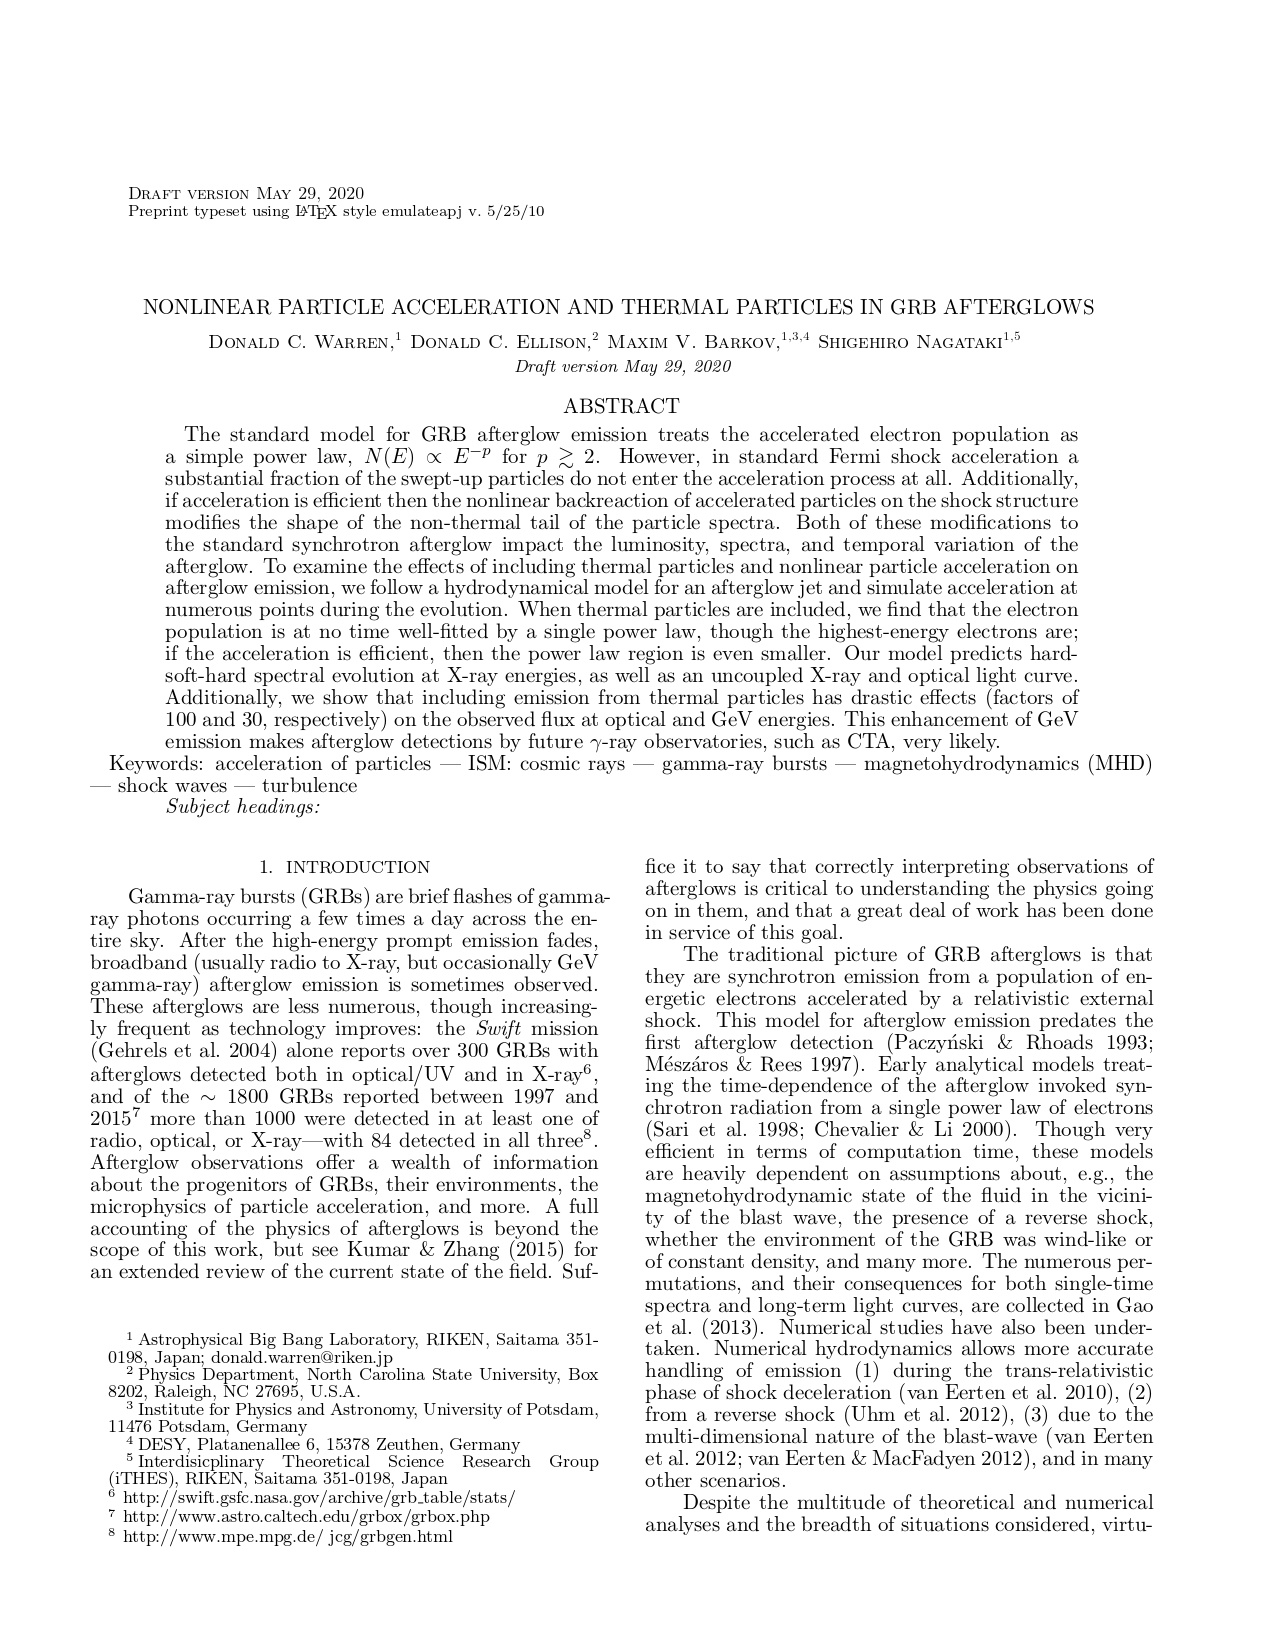

In [4]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite(intermediate_dir + 'Grayimage.jpg', gray)
display(Image.open(intermediate_dir + 'Grayimage.jpg'))

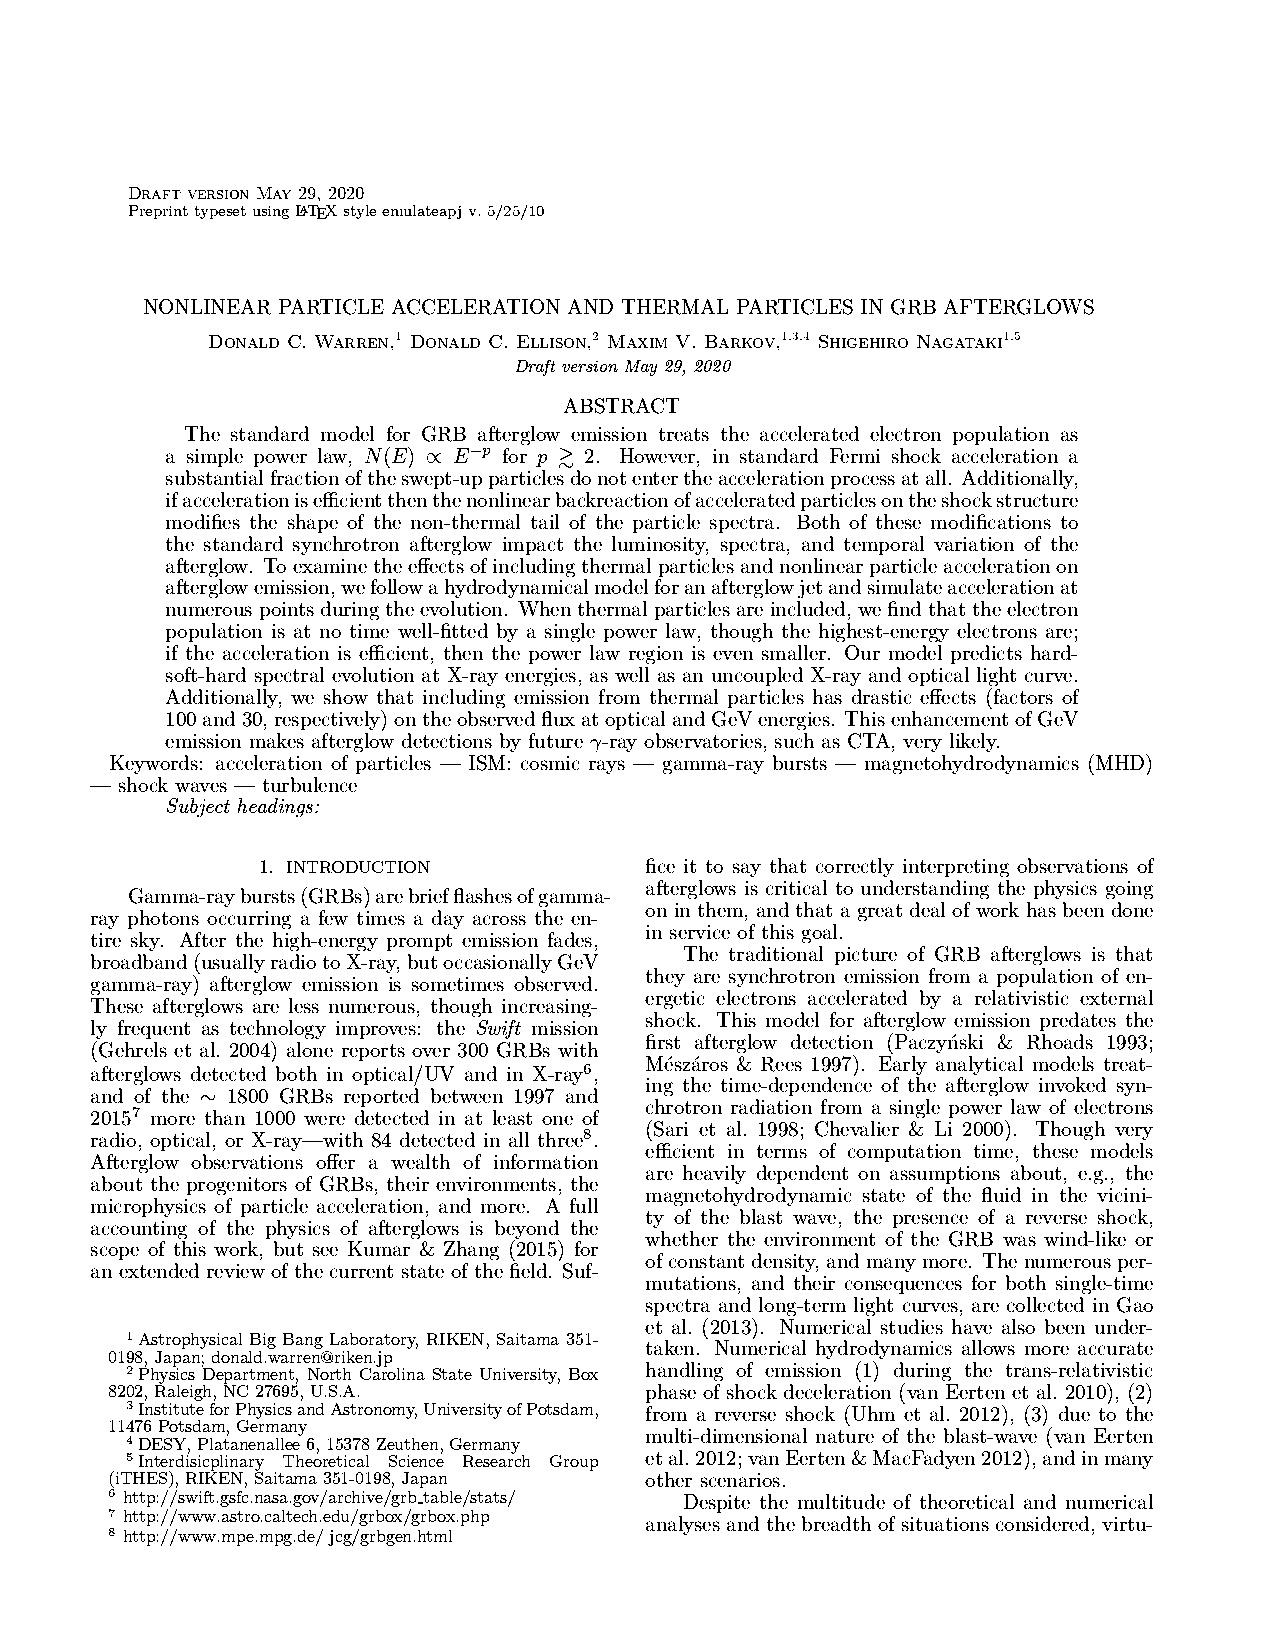

In [5]:
# Convert the grayscale image to binary
ret, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_OTSU)
cv2.imwrite(intermediate_dir + 'Binaryimage.jpg', binary)
display(Image.open(intermediate_dir + 'Binaryimage.jpg'))

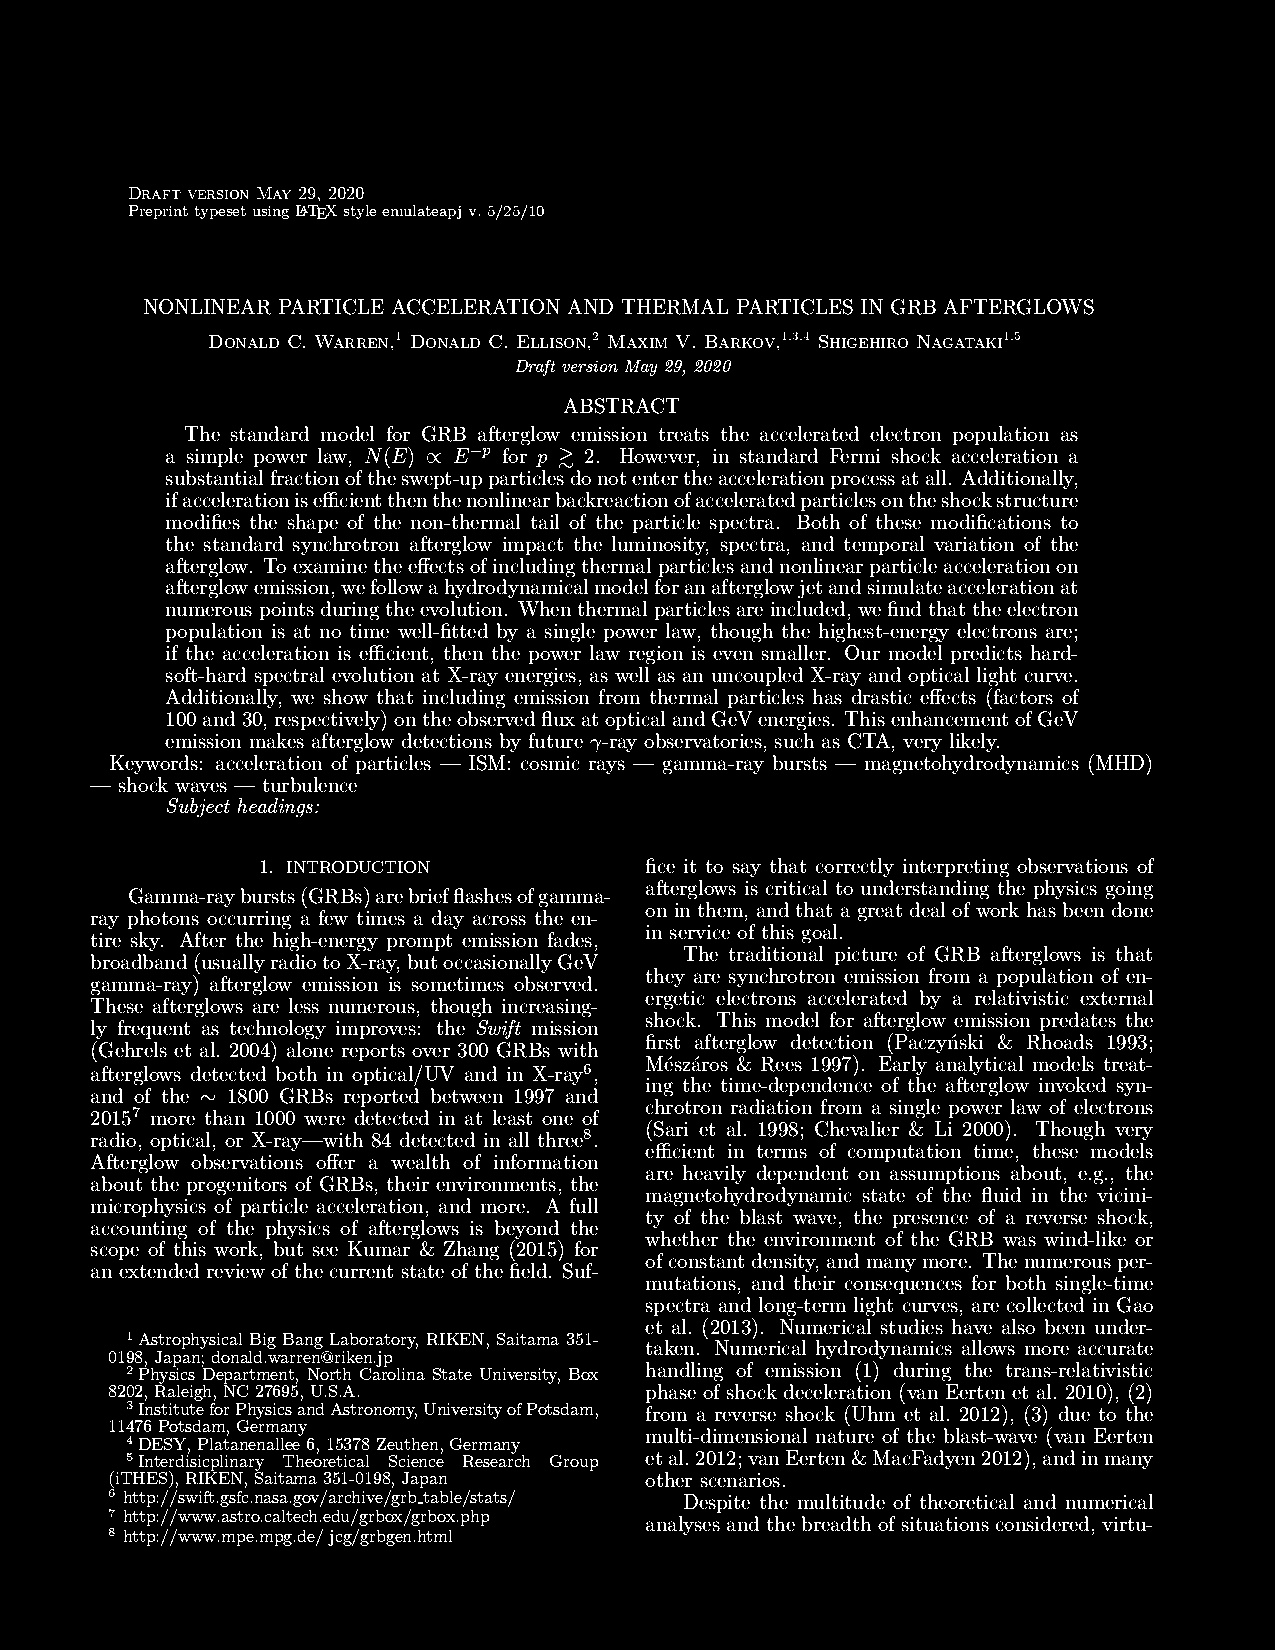

In [6]:
# To detect object contours, we want a black background and a white 
# foreground, so we invert the image (i.e. 255 - pixel value)
inverted_binary = ~binary
cv2.imwrite(intermediate_dir + 'Invertedbinaryimage.jpg', inverted_binary)
display(Image.open(intermediate_dir + 'Invertedbinaryimage.jpg'))

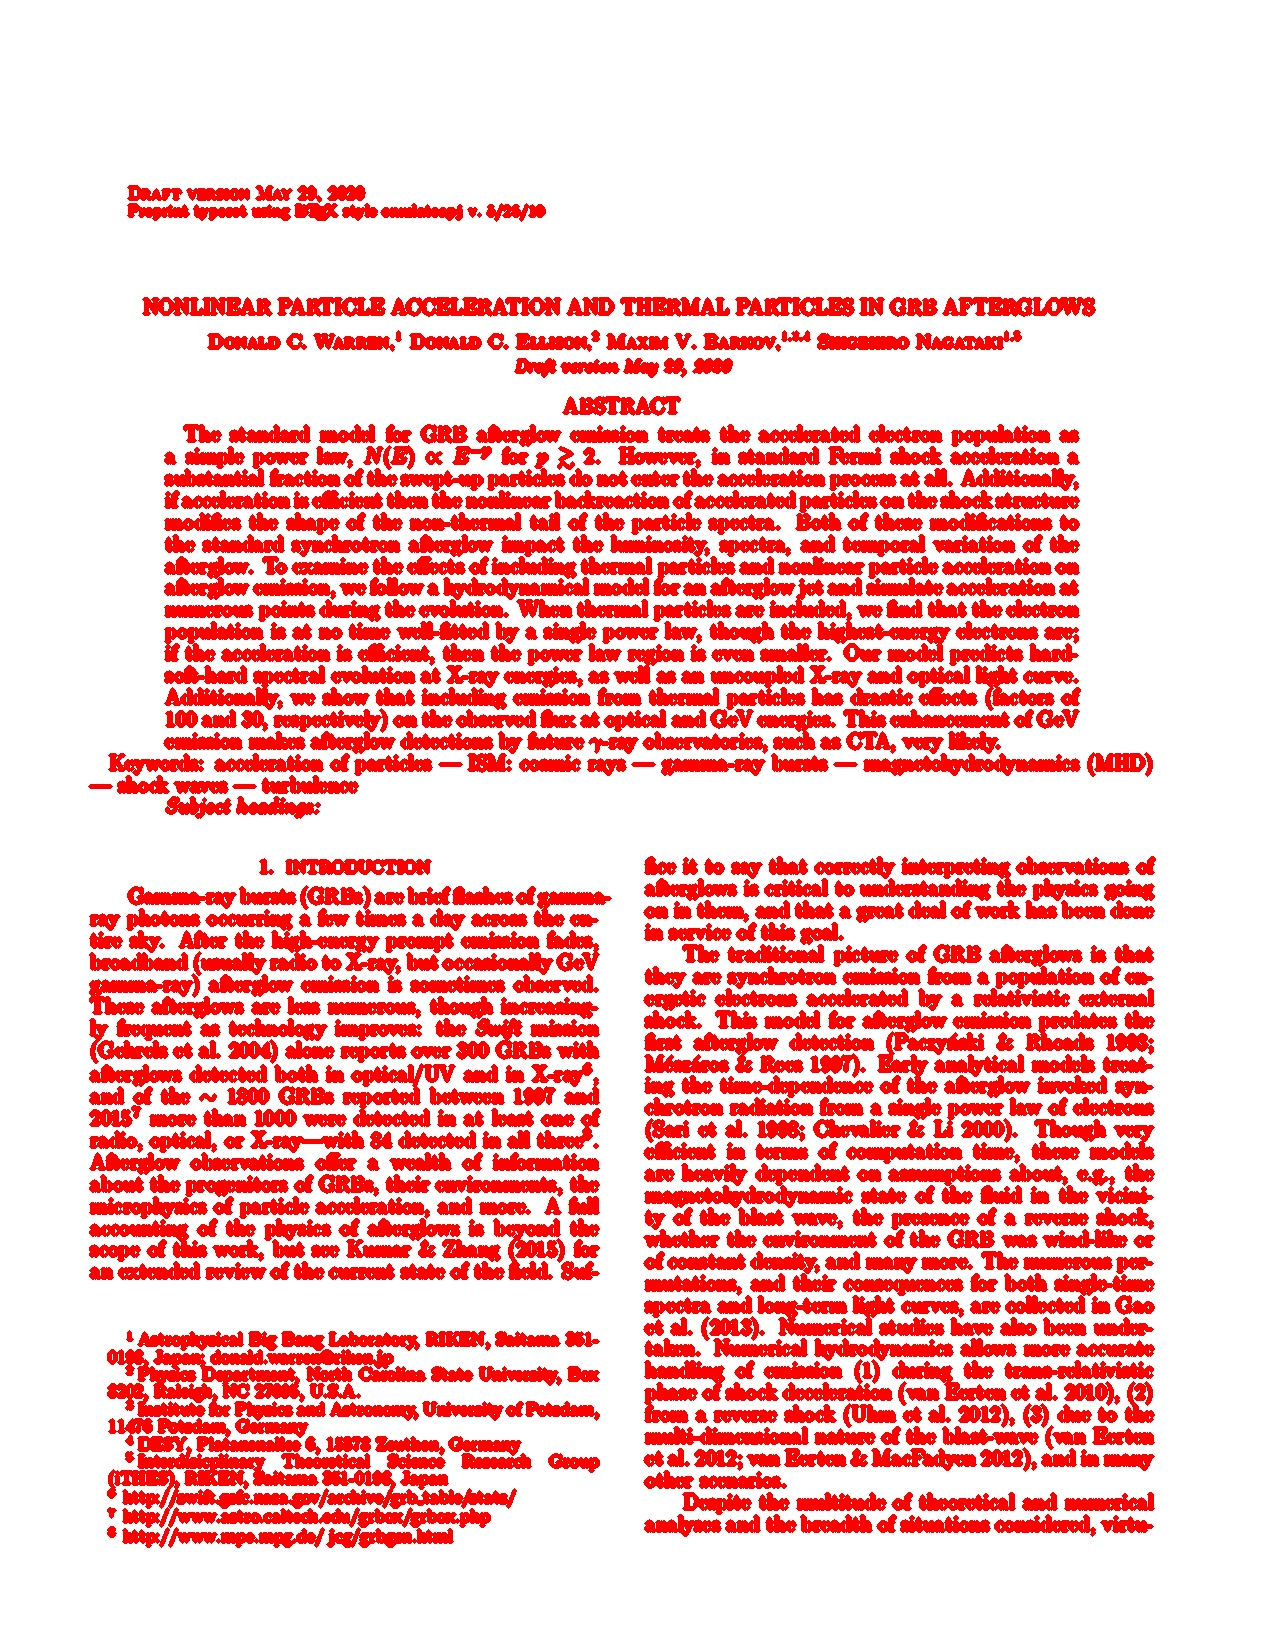

In [7]:
# Find the contours on the inverted binary image, and store them in a list
# Contours are drawn around white blobs.
# hierarchy variable contains info on the relationship between the contours
contours, hierarchy = cv2.findContours(inverted_binary,
  cv2.RETR_TREE,
  cv2.CHAIN_APPROX_SIMPLE)

#This is inmtermediate contour image having red contours plotted along the letters
with_contours_int = cv2.drawContours(image, contours, -1,(0,0,255),4)
cv2.imwrite(intermediate_dir + 'DetectedcontoursIntermediate.jpg', with_contours_int)
display(Image.open(intermediate_dir + 'DetectedcontoursIntermediate.jpg'))

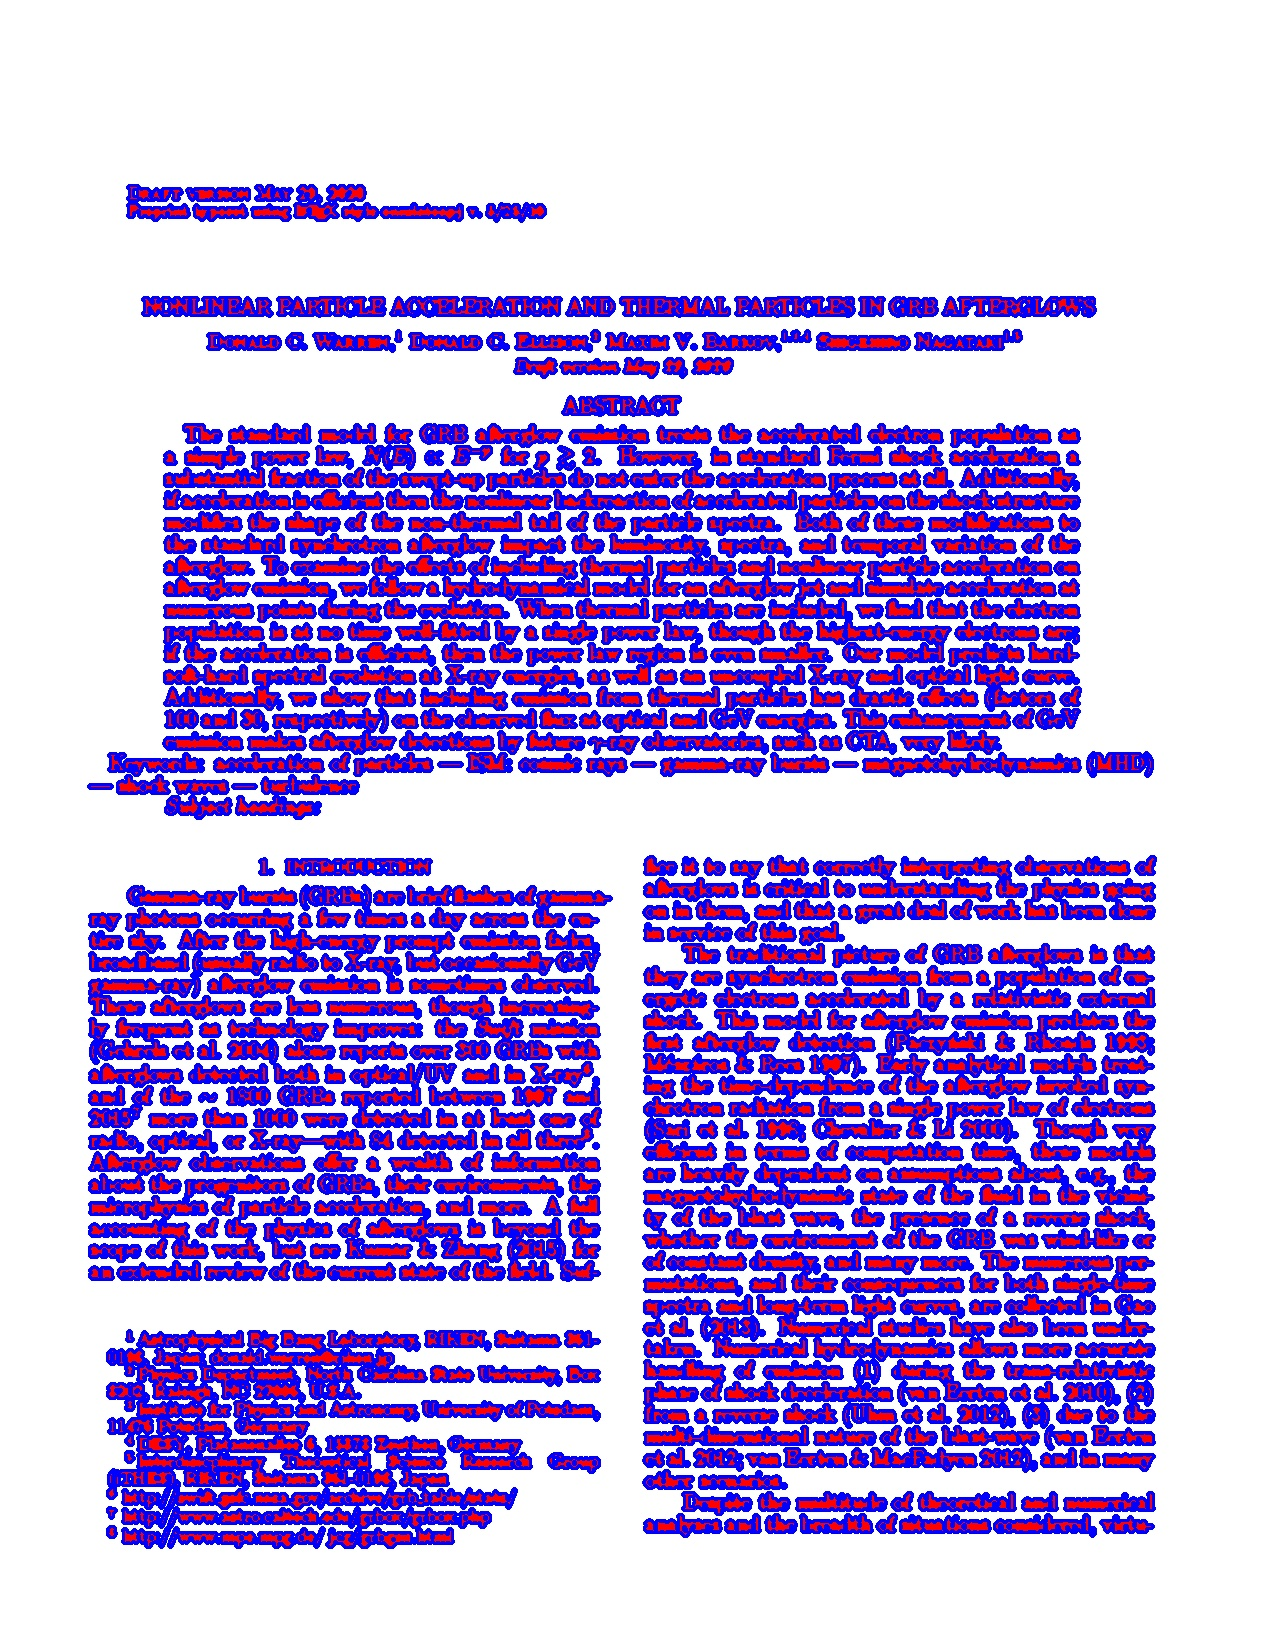

In [8]:
#We again perform binarization of above image inorder to find contours again 
gray_contour = cv2.cvtColor(with_contours_int, cv2.COLOR_BGR2GRAY)

ret, binary_contour = cv2.threshold(gray_contour, 100, 255, 
  cv2.THRESH_OTSU)
inverted_contour = ~binary_contour

# We find contours again of this inverted binary map so that word boundaries are detected
contours, hierarchy = cv2.findContours(inverted_contour,
  cv2.RETR_TREE,
  cv2.CHAIN_APPROX_SIMPLE)

#New contours are blue in colour to identify word bounds
with_contours = cv2.drawContours(with_contours_int, contours, -1,(255,0,0),2)
cv2.imwrite(intermediate_dir + 'Detectedcontours.jpg', with_contours)
display(Image.open(intermediate_dir + 'Detectedcontours.jpg'))

In [9]:
# Show the total number of contours that were detected
print('Total number of contours detected: ' + str(len(contours)))

Total number of contours detected: 3642


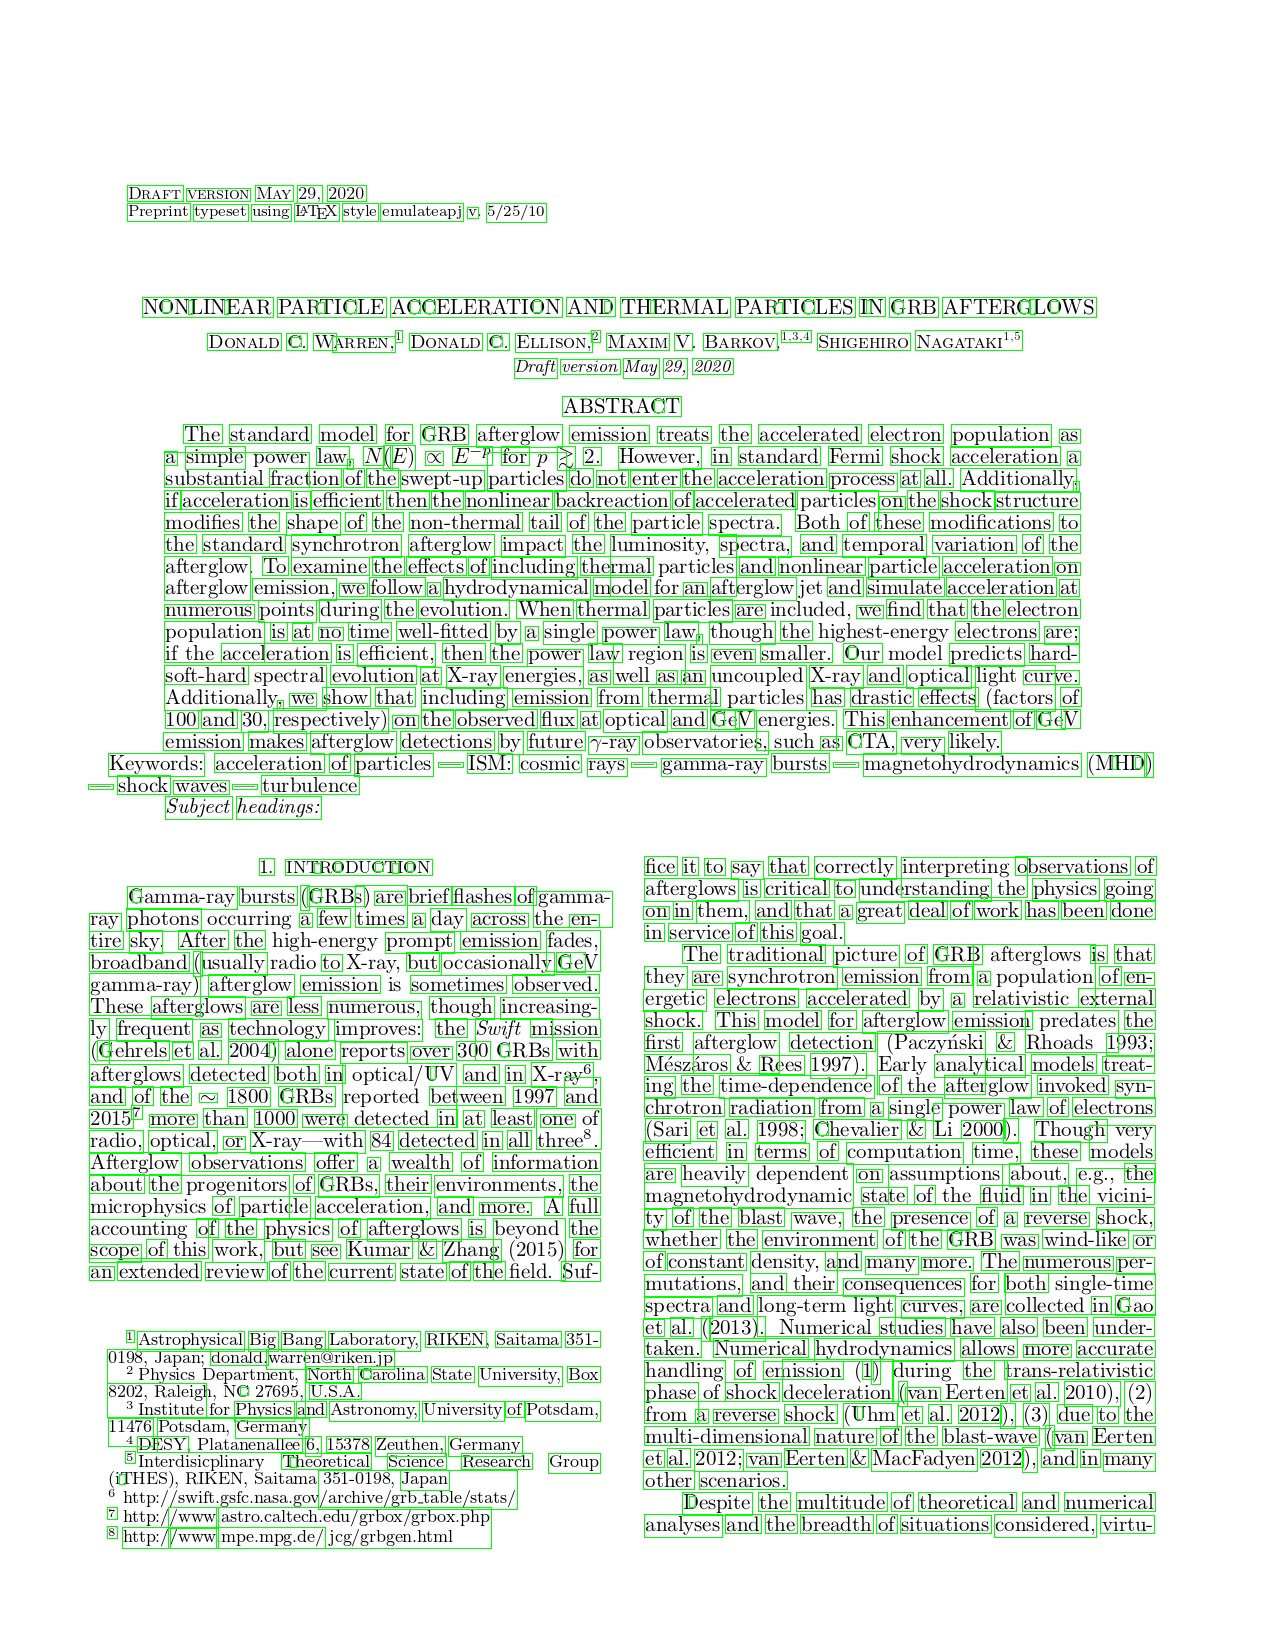

In [10]:
origimage = cv2.imread(imgfile)
# Draw a bounding box around all contours
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
 
    # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 30 and h <80:
        cv2.rectangle(origimage,(x,y), (x+w,y+h), (0,255,0), 1)
         
cv2.imwrite(output_dir + 'Imagewithboundingboxes.jpg', origimage)
display(Image.open(output_dir + 'Imagewithboundingboxes.jpg'))

### Define a function for text detection

In [14]:
def detect_text_boxes(input_dir, imgfile, output_dir):
    imgpath = input_dir + imgfile
    image = cv2.imread(imgpath)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Convert the grayscale image to binary
    ret, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_OTSU)
    inverted_binary = ~binary
    contours, hierarchy = cv2.findContours(inverted_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    with_contours_int = cv2.drawContours(image, contours, -1,(0,0,255),4)
    #We again perform binarization of above image inorder to find contours again 
    gray_contour = cv2.cvtColor(with_contours_int, cv2.COLOR_BGR2GRAY)
    ret, binary_contour = cv2.threshold(gray_contour, 100, 255, cv2.THRESH_OTSU)
    inverted_contour = ~binary_contour
    # We find contours again of this inverted binary map so that word boundaries are detected
    contours, hierarchy = cv2.findContours(inverted_contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #New contours are blue in colour to identify word bounds
    with_contours = cv2.drawContours(with_contours_int, contours, -1,(255,0,0),2)
    origimage = cv2.imread(imgpath)
    
    values = []
    # Draw a bounding box around all contours
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        # Make sure contour area is large enough
        if (cv2.contourArea(c)) > 30 and h <80:
            values.append([x, y, x + w, y + h])
            cv2.rectangle(origimage,(x,y), (x+w,y+h), (0,255,0), 1)
    cv2.imwrite(output_dir + imgfile, origimage)
    return values

In [15]:
dimensions = {}
results = {}

for image in dir_list:
    img_file = location + image
    values = detect_text_boxes(location, image, output_dir)
    dimensions[image] = values

### Store Results

In [17]:
with open(output_dir+'dimensions.pkl', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(dimensions, outp, pickle.HIGHEST_PROTOCOL)